In [2]:
# read in data
import json
file_path = 'inference_qa_split.json'
datas = []
with open(file_path, 'r') as file:
    for data in file:
        datas.append(json.loads(data))

        
print(len(datas))

12877


In [3]:
# process data to paper chunk
a = ''
idx = 0
for i in datas[idx]['paper'][:-1]:
    a += i.replace(' but wait, I have more information to add, just answer with YES', '')

a += datas[idx]['paper'][-1].replace(" \nNow, please generate 10 scientific Q&A (prompts with outputs) using the information in the scientific paper. \nDon't ask very simple questions, like definition questions (e.g. What is XXX). You should generate more complex problems. The question is better to be related with compound name (eg. Al2O3, C2H5OH, TNT...). DO NOT generate duplicated Q&A pairs. DO NOT repeat the instruction or input. Answer using the data from input information. Add details to answers as much as possible, such as answer the specific chemical elements and numbers. \n\n<\\s>", '')

print(len(a.split(' ')))

2989


In [ ]:
# attention
from transformers import AutoTokenizer, AutoModel, utils
import torch
utils.logging.set_verbosity_error()  # Suppress standard warnings
tokenizer = AutoTokenizer.from_pretrained("/data/share2T/model/darwin2/vicuna2_gadi_2048/")
model = AutoModel.from_pretrained("/data/share2T/model/darwin2/vicuna2_gadi_2048/", output_attentions=True)

sep_token = '[SEP]'
tokenizer.add_special_tokens({'additional_special_tokens': [sep_token]})
model.resize_token_embeddings(len(tokenizer))

def cal_attention(sentence_a, sentence_b):
    input_ids = tokenizer.encode(sentence_a + sep_token + sentence_b, return_tensors='pt')
    outputs = model(input_ids)
    attention = outputs[-1]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    sep_index = tokens.index(sep_token)
    sentence_a_indices = range(0, sep_index)
    sentence_b_indices = range(sep_index + 1, len(tokens))
    # Extract attention from sentence A to sentence B
    sentence_a_to_b_attention = attention[-1][0].sum(dim=0)[sentence_b_indices, :][:, sentence_a_indices]
    return sentence_a_to_b_attention.mean(dim=0).detach().numpy()[1:]
    # file_path = 'attention_prompt_QA.pth'
    # torch.save(sentence_a_to_b_attention, file_path)

In [ ]:
# get input sentence token
def get_token(sentence_a, sentence_b):
    input_ids = tokenizer.encode(sentence_a + sep_token + sentence_b, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    sep_index = tokens.index(sep_token)
    return tokens[1:sep_index]

token_li = []
for a in a_li:
    b = f'Q: {qa["Q"]}\nA: {qa["A"]}'
    token_li += get_token(a, b)

In [ ]:
# input vs qa
import numpy as np

data_idx = 0
a_li = []

dir = str(data_idx)
if not os.path.exists(dir):
    os.makedirs(dir)
    print(f"Directory created: {dir}")
else:
    print(f"Directory already exists: {dir}")

for i in datas[data_idx]['paper'][:-1]:
    a_li.append(i.replace(' but wait, I have more information to add, just answer with YES', ''))

a_li.append(datas[data_idx]['paper'][-1].replace(" \nNow, please generate 10 scientific Q&A (prompts with outputs) using the information in the scientific paper. \nDon't ask very simple questions, like definition questions (e.g. What is XXX). You should generate more complex problems. The question is better to be related with compound name (eg. Al2O3, C2H5OH, TNT...). DO NOT generate duplicated Q&A pairs. DO NOT repeat the instruction or input. Answer using the data from input information. Add details to answers as much as possible, such as answer the specific chemical elements and numbers. \n\n<\\s>", ''))

for idx, qa in enumerate(datas[data_idx]['Q&A']):
    b = f'Q: {qa["Q"]}\nA: {qa["A"]}'
    tokenavg = np.array([])
    for a in a_li:
       tokenavg = np.concatenate((tokenavg, cal_attention(a, b)), axis=0)
       
    file_path = f'{data_idx}/QA{idx+1}.pth'
    torch.save(tokenavg, file_path)

    

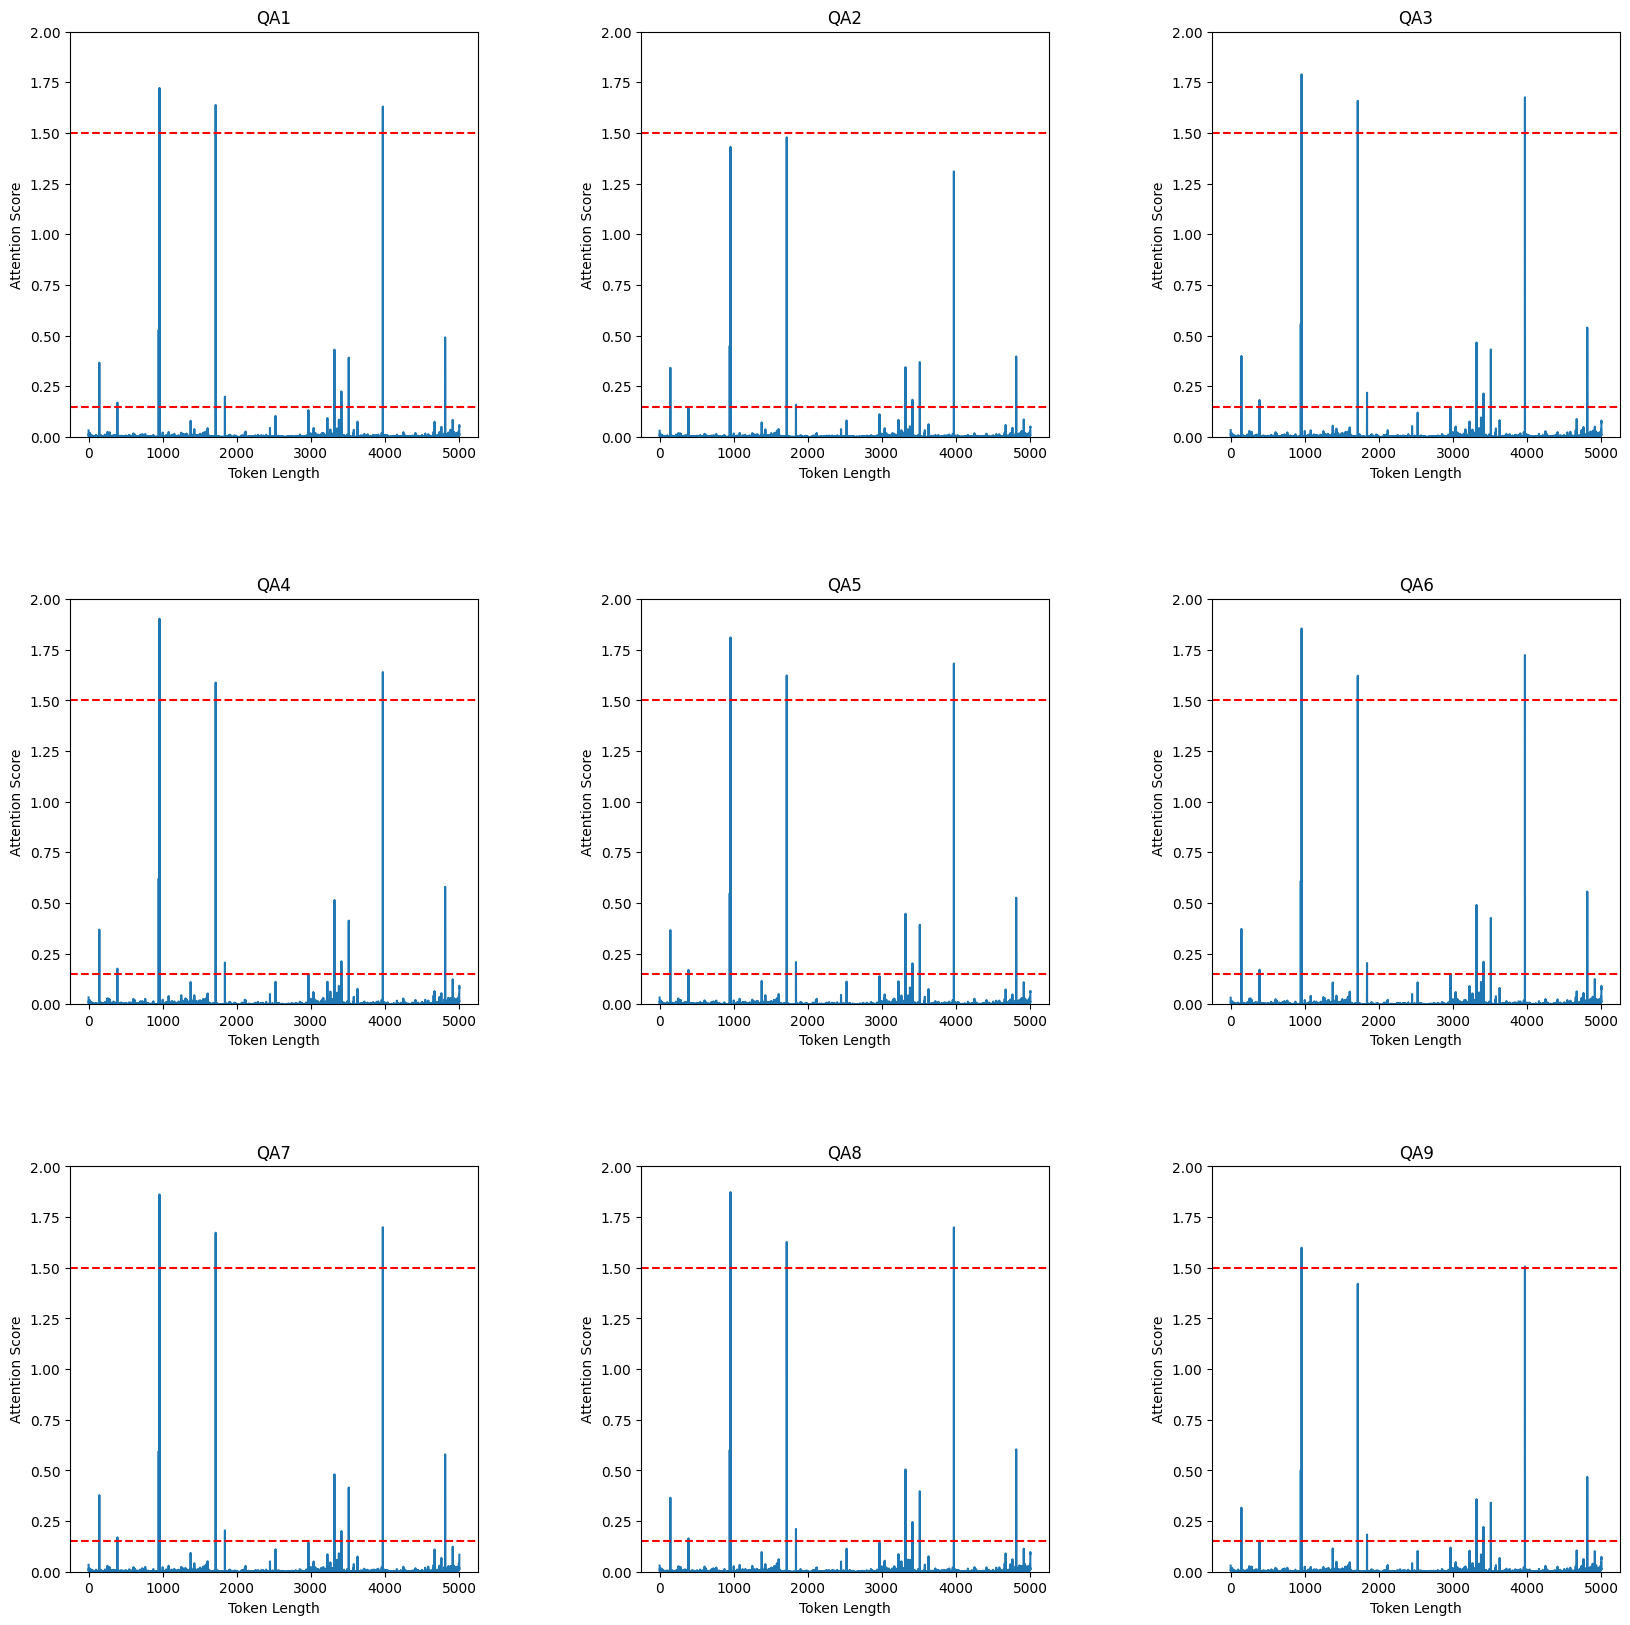

In [5]:
# visualization
import matplotlib.pyplot as plt
import torch

# Set up a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Adjust figsize as needed
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing as needed

data_idx = 0
num = datas[data_idx]['num_Q&A']

for i in range(1, num+1):
    file_path = f'attention/{data_idx}/QA{i}.pth'
    # print(file_path)
    attention = torch.load(file_path)

    # Determine the position of the current subplot
    row = (i - 1) // 3
    col = (i - 1) % 3

    # Select the subplot
    ax = axes[row, col]

    # Plot the attention
    ax.plot(range(len(attention)), attention)

    # Set the title for each subplot
    ax.set_title(f'QA{i}')
    ax.set_ylim(0, 2)
    ax.axhline(y=0.15, color='r', linestyle='--')
    ax.axhline(y=1.5, color='r', linestyle='--')


    # Set x and y labels for each subplot (optional)
    ax.set_xlabel('Token Length')
    ax.set_ylabel('Attention Score')

# Show the plot
plt.show()
# plt.savefig('attention/0/fig.png')


attention/0/QA1.pth
attention/0/QA2.pth
attention/0/QA3.pth
attention/0/QA4.pth
attention/0/QA5.pth
attention/0/QA6.pth
attention/0/QA7.pth
attention/0/QA8.pth
attention/0/QA9.pth


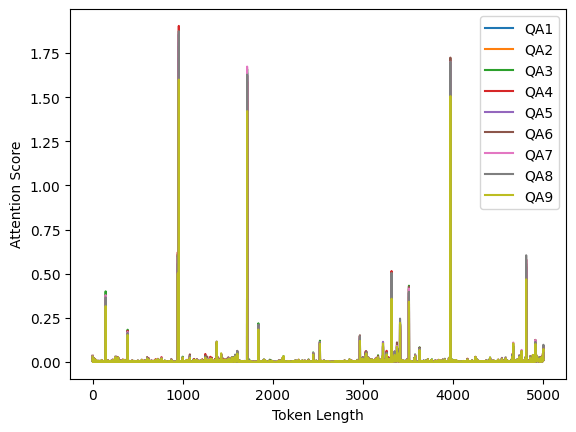

In [6]:
import numpy as np

data_idx = 0
num = datas[data_idx]['num_Q&A']
for i in range(1,num+1):
    file_path = f'attention/{data_idx}/QA{i}.pth'
    print(file_path)
    attention = torch.load(file_path)

    plt.plot(range(len(attention)), attention, label=f'QA{i}')

plt.legend()
plt.xlabel('Token Length')
plt.ylabel('Attention Score')
# plt.title('Line Plot of Tensors')
plt.show()


In [7]:
# get token with attention > 0.15
file_path = f'attention/0/QA1.pth'
attention = torch.load(file_path)

di = {idx: (token_li[idx], i) for idx, i in enumerate(attention) if i>0.15}
di

NameError: name 'token_li' is not defined